# Computational Physics
## Fast Fourier Transform

<img src="https://groups.csail.mit.edu/netmit/sFFT/images/sFFT5.png" width=600px>

In [1]:
import style
style._set_css_style('../include/bootstrap.css')

## Last Time

### [Notebook Link: 21 Spectral Analysis](./21_SpectralAnalysis.ipynb)

- Spectral analysis
- Discrete Fourier transform
- Nyquist frequency


## Today

- Fast Fourier transform

## Setting up the Notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('../include/notebook.mplstyle');
%config InlineBackend.figure_format = 'svg'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Discrete Fourier Transform

For a discrete time series $\vec{y}$ measured at times $t_j = j \Delta t$, the discrete Fourier transform is given by:

\begin{equation}
\hat{y}_k  = \sum_{j=0}^{N-1} y_j \mathrm{e}^{-i 2\pi k j /N} .
\end{equation}

for $k=0,\ldots,N-1$.  The minimum non-zero frequency is $\omega_{\rm min} = 2\pi/(N\Delta t)$ while the maximum frequency is given by: $\omega_{\rm Ny} = \pi/\Delta t$.

Last time we considered a *brute force* implementation of $\hat{y}_k$ that is formally of order $\mathrm{O}(N^2)$.  We have to perform $N$ summations, each containint $N$ terms.  Historically, when computational abilities were more limited, this scaling prevented a **big** problem and better algorithms were needed.

In [3]:
from scipy.constants import pi as π
def fourier_transform(t,y):
    '''Return the discrete Fourier transform of y.'''
    N = y.size
    Δt = t[1]-t[0]
    ŷ = np.zeros([N],dtype=complex)
    
    for k in range(N):
        ŷ[k] = np.sum(y*np.exp(-complex(0,1)*2*π*np.arange(N)*k/N))
        
    ω = 2*π*np.arange(N)/(N*Δt)
    
    return ω,ŷ

## Fast Fourier Transform

In 1965, Cooley and Tukey introduced an algorithm, now known as the *fast fourier transform* (FFT) which is of order: $\mathrm{O}(N\log_2N)$ *provided* that $N=2^n;\; n\in\mathbb{Z}$.  Deriving the algorithm is quite complicated, but all languages provide **black box** routines to return the FFT.  It can be evaluated in Python via `np.fft.fft`: https://docs.scipy.org/doc/numpy/reference/routines.fft.html

A nice video which includes a step-by-step derivation is below

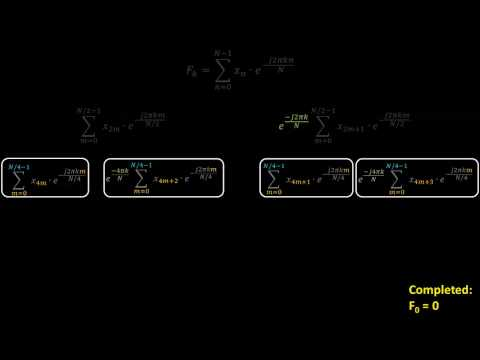

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('htCj9exbGo0')

In [5]:
def fast_fourier_transform(t,y):
    '''Return the fast Fourier transform of y.'''
    ŷ = np.fft.fft(y)
    ω = 2*π*np.fft.fftfreq(t.size,t[1]-t[0])
    return ω,ŷ

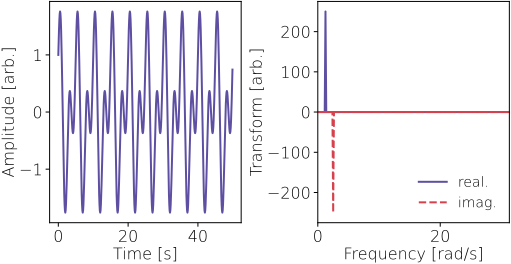

In [6]:
# the time series
Δt = 0.1
t = np.arange(0.0,50.0,Δt)
ωₒ = 2.0*π*(0.2)
ϕ = 0.5*π
y = np.sin(ωₒ*t + ϕ) + np.sin(2*ωₒ*t)

# Plot the time series
fig,ax = plt.subplots(1,2, figsize=(8,4))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t,y)
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude [arb.]')

# # Get the discrete FT
ω,ŷ = fast_fourier_transform(t,y)

# Plot the real and imaginary parts of the DFT
ax[1].plot(ω,ŷ.real,label='real.', color=colors[0])
ax[1].plot(ω,ŷ.imag,linestyle='--',label='imag.', color=colors[-2])

ax[1].set_xlabel('Frequency [rad/s]')
ax[1].set_ylabel('Transform [arb.]')
ax[1].set_xlim(0,np.max(ω))
ax[1].legend(loc='lower right')

<div class="span alert alert-danger">
np.fft.fft wraps frequencies above the Nyquist frequency to $\omega < 0$.
</div>

### Let's confirm the speedup factor

In [7]:
import timeit
N = np.array([2**n for n in range(6,15)])
dft,fft = [],[]
for cN in N:
    t = np.linspace(0,20,cN)
    y = np.sin(t)
    
    dft.append(timeit.timeit('fourier_transform(t,y)', number=1, globals=globals()))
    fft.append(timeit.timeit('fast_fourier_transform(t,y)', number=1, globals=globals()))
    
dft = np.array(dft)
fft = np.array(fft)

### Try to fit the cuves

In [8]:
from scipy.optimize import curve_fit

def N2(x,*a):
    '''N^2'''
    return a[0] + a[1]*x**2

def NlogN(x,*a):
    '''power function.'''
    return a[0] + a[1]*x*np.log2(x)

# perform the fits
a1,a1_cov = curve_fit(N2,N,dft,p0=(1,1))
a2,a2_cov = curve_fit(NlogN,N,fft,p0=(1,1))

### Plot the results

Text(0, 0.5, 'Execution Time [s]')

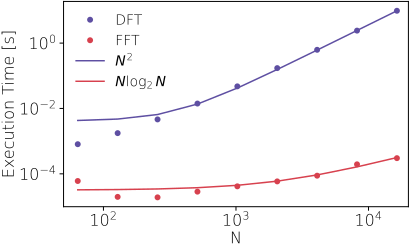

In [9]:
# plot the timing results
plt.loglog(N,dft,'o', markersize=6, mec='None', mfc=colors[0], label='DFT')
plt.loglog(N,fft,'o', markersize=6, mec='None', mfc=colors[-2], label='FFT')

# Plot the fits
plt.loglog(N,N2(N,*a1),'-', color=colors[0], zorder=0, linewidth=1.5, label=r'$N^2$')
plt.loglog(N,NlogN(N,*a2),'-', color=colors[-2], zorder=0, linewidth=1.5, label=r'$N\log_2N$')

plt.xlim(50,20000)
plt.legend(loc='upper left')
plt.xlabel('N')
plt.ylabel('Execution Time [s]')

<div class="span alert alert-success">
<h2> Group Programming challenge </h2>
Revisit the driven dissipative non-linear pendulum and plot the power spectrum for $F_D = 0.5,1.2$.  What does this tell you about the onset/origin of chaos?
</div>

In [10]:
from scipy.constants import g
from scipy.constants import pi as π
def euler(t,FD,ℓ,θₒ,ωₒ,γ,ΩD):
    ''' Semi-implicit Euler Method for the non-linear, dissipative, driven pendulum.'''
    
    Δt = t[1]-t[0]
    ω,θ = np.zeros_like(t),np.zeros_like(t)
    θ[0],ω[0] = θₒ,ωₒ
    
    # perform the numerical integration
    for n in range(t.size-1):
        ω[n+1] = ω[n] + (-(g/ℓ)*np.sin(θ[n]) - γ*ω[n] + FD*np.sin(ΩD*t[n]))*Δt
        θ[n+1] = θ[n] + ω[n+1]*Δt
        
        # keep theta in [-pi,pi)
        if θ[n+1] < -π: θ[n+1] += 2.0*π
        if θ[n+1] >= π: θ[n+1] -= 2.0*π 

    return θ

### Setup initial conditions

In [11]:
params = ℓ,θₒ,ω0,γ,ΩD = g, 0.2, 0.0, 0.5, 2.0/3.0
FD = [0.5,1.2]
Δt = 0.01

# We determine the maximum time such that N = 2*n

N = 70000

# setup the time array

t = np.arange(0.0,N*Δt,Δt)

### Perform a spectral analysis of θ(t) for the different values of driving force defined above

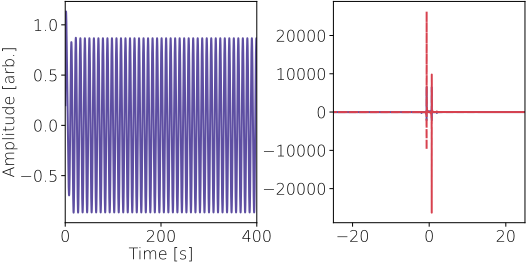

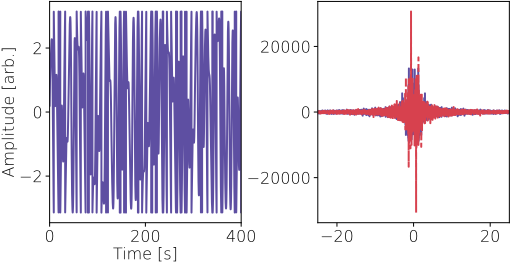

In [12]:
theta_tuple = (euler(t,FD[0],ℓ,θₒ,ωₒ,γ,ΩD), euler(t,FD[1],ℓ,θₒ,ωₒ,γ,ΩD))

# Plotting the results 
for n in range(2):
    
    θ = theta_tuple[n]
    ω,ŷ = fast_fourier_transform(t,θ)
    fig,ax = plt.subplots(1,2, figsize=(8,4))
    fig.subplots_adjust(wspace=0.4)
    
    ax[0].plot(t,θ)
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Amplitude [arb.]')
    ax[0].set_xlim(0,400)
    
    ax[1].plot(ω,ŷ.real,label='real.', color=colors[0])
    ax[1].plot(ω,ŷ.imag,linestyle='--',label='imag.', color=colors[-2])
    ax[1].set_xlim(-25,25)

